In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Load dataset

In [2]:
dataset_nodes = pd.read_csv('extracted_nodes.csv',
                            header=None, index_col=False,
                            names=['hour', 'nodeID', 'demand_value', 'head_value', 'pressure_value', 'x_pos', 'y_pos', 'node_type'])

In [3]:
dataset_edges = pd.read_csv('extracted_links.csv',
                            header=None, index_col=False,
                            names=['hour', 'pipeID', 'pipe_flow', 'pipe_velocity', 'pipe_headloss', 'start_node', 'end_node', 'node_type'])

## Build Graph

In [4]:
G = nx.Graph()

### Add Nodes

In [5]:
demand = dataset_nodes.groupby('nodeID').demand_value.sum().to_dict()

In [6]:
dataset_nodes[dataset_nodes.hour=='0:00:00'].apply(lambda row: G.add_node(row.nodeID, id=row.nodeID,
                                                                         x_pos=row.x_pos,
                                                                         y_pos=row.y_pos,
                                                                         demand=demand[row.nodeID]), axis=1)

0     None
1     None
2     None
3     None
4     None
      ... 
69    None
70    None
71    None
72    None
73    None
Length: 74, dtype: object

### Add Edges

In [7]:
flow = dataset_edges.groupby('pipeID').pipe_flow.sum().to_dict()

In [8]:
dataset_edges[dataset_edges.hour=='0:00:00'].apply(lambda row: G.add_edge(row.start_node, row.end_node,
                                                                          id=row.pipeID,
                                                                         flow=flow[row.pipeID]), axis=1)

0     None
1     None
2     None
3     None
4     None
      ... 
72    None
73    None
74    None
75    None
76    None
Length: 77, dtype: object

In [9]:
nx.info(G)

/tmp/ipykernel_141127/1064119803.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 75 nodes and 77 edges'

## Visualize Graph

In [10]:
pos = dataset_nodes[dataset_nodes.hour=='0:00:00'].set_index('nodeID')[['x_pos', 'y_pos']].apply(lambda row: (row.x_pos, row.y_pos), axis=1).to_dict()

In [48]:
dataset_edges[dataset_edges.end_node == 8610]

,hour,pipeID,pipe_flow,pipe_velocity,pipe_headloss,start_node,end_node,node_type
6,0:00:00,10113,1.92,0.01,0.0,8608,8610,Pipe
83,1:00:00,10113,2.03,0.01,0.0,8608,8610,Pipe
160,2:00:00,10113,2.08,0.01,0.0,8608,8610,Pipe
237,3:00:00,10113,1.93,0.01,0.0,8608,8610,Pipe
314,4:00:00,10113,1.69,0.01,0.0,8608,8610,Pipe
...,...,...,...,...,...,...,...,...
12634,164:00:00,10113,2.36,0.02,0.0,8608,8610,Pipe
12711,165:00:00,10113,2.11,0.01,0.0,8608,8610,Pipe
12788,166:00:00,10113,1.71,0.01,0.0,8608,8610,Pipe
12865,167:00:00,10113,1.26,0.01,0.0,8608,8610,Pipe


In [11]:
pos[8610] = (dataset_nodes.x_pos.min(), dataset_nodes.y_pos.min())
demand[8610] = 0

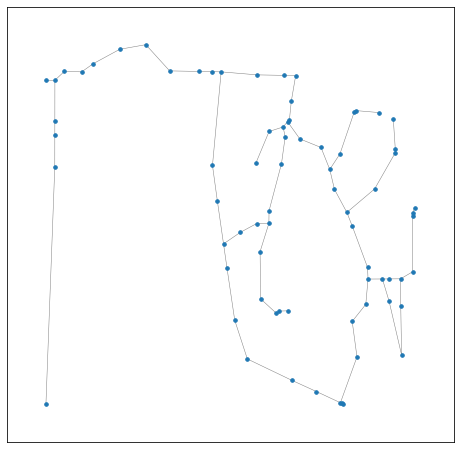

In [12]:
plt.figure(figsize=(8,8))
plt.clf()
nx.draw_networkx_nodes(G, pos=pos, node_shape='.', node_size=50)
nx.draw_networkx_edges(G, pos=pos, width=0.5, alpha=0.5)
plt.show()

### Flow/Demand-based

In [13]:
q90 = dataset_nodes.groupby('nodeID').demand_value.sum().quantile(q=0.9)
q10 = dataset_nodes.groupby('nodeID').demand_value.sum().quantile(q=0.1)

for node in G.nodes():
    if (demand[node] >= q90):
        G.nodes[node]['demand_size'] = 300
    elif (demand[node] <= q10):
        G.nodes[node]['demand_size'] = 25
    else:
        G.nodes[node]['demand_size'] = 100

In [14]:
q90 = dataset_edges.groupby('pipeID').pipe_flow.sum().quantile(q=0.9)
q10 = dataset_edges.groupby('pipeID').pipe_flow.sum().quantile(q=0.1)

for edge in G.edges():
    pipeID = G.edges[edge]['id']
    if (flow[pipeID] >= q90):
        G.edges[edge]['pipe_flow'] = 3
    elif (flow[pipeID] <= q10):
        G.edges[edge]['pipe_flow'] = 0.5
    else:
        G.edges[edge]['pipe_flow'] = 1

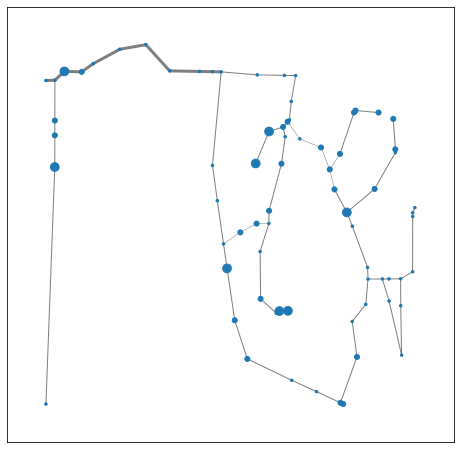

In [15]:
plt.figure(figsize=(8,8))
plt.clf()
nx.draw_networkx_nodes(G, pos=pos, 
                       node_shape='.', 
                       node_size=list(nx.get_node_attributes(G, 'demand_size').values()))
nx.draw_networkx_edges(G, pos=pos, alpha=0.5,
                      width=list(nx.get_edge_attributes(G, 'pipe_flow').values()))
plt.show()     

## Analyze Graph

### Degrees

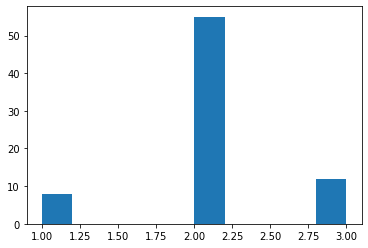

In [16]:
plt.figure()
plt.hist(list(dict(nx.degree(G)).values()), bins=10)
plt.show()

### Centrality

In [17]:
def compute(I, node_pos, centrality_dict):
    q90 = pd.DataFrame.from_dict(centrality_dict, orient='index').quantile(q=0.9)[0]
    q10 = pd.DataFrame.from_dict(centrality_dict, orient='index').quantile(q=0.1)[0]
        
    for node in I.nodes():
        if (centrality_dict[node] >= q90):
            I.nodes[node]['size'] = 300
        elif (centrality_dict[node] <= q10):
            I.nodes[node]['size'] = 25
        else:
            I.nodes[node]['size'] = 100
            
    plt.figure(figsize=(8,8))
    plt.clf()
    nx.draw_networkx_nodes(I, pos=node_pos, 
                           node_shape='.', 
                           node_size=list(nx.get_node_attributes(I, 'size').values()))
    nx.draw_networkx_edges(I, pos=node_pos, width=0.5, alpha=0.5)
    plt.show()            

#### Degree Centrality

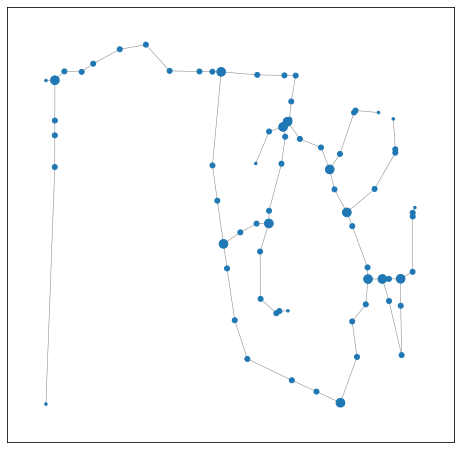

In [18]:
compute(G, pos, nx.degree_centrality(G))

#### Betweeness Centrality

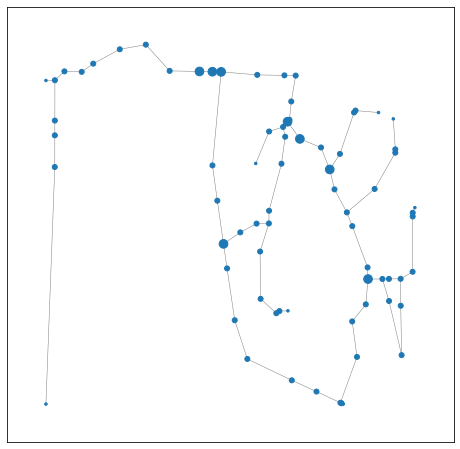

In [19]:
compute(G, pos, nx.betweenness_centrality(G))

#### Load Centrality

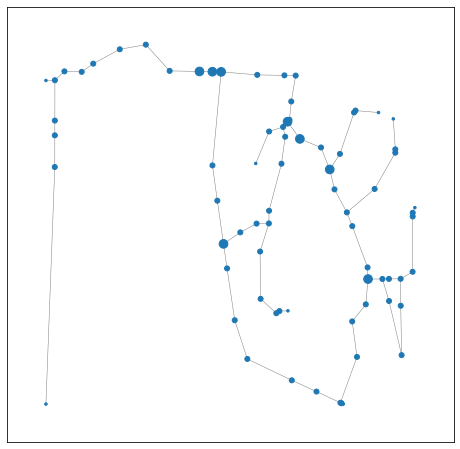

In [20]:
compute(G, pos, nx.load_centrality(G))

#### Closeness Centrality

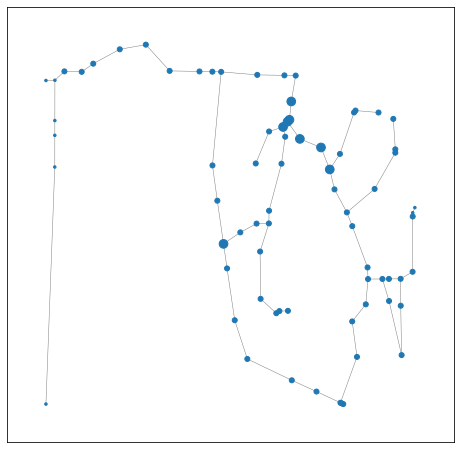

In [21]:
compute(G, pos, nx.closeness_centrality(G))

#### Current-flow Closeness Centrality

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


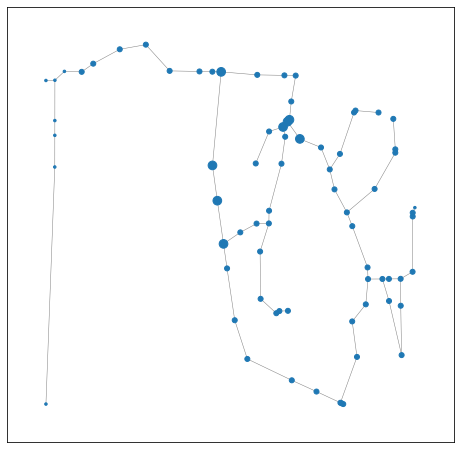

In [22]:
compute(G, pos, nx.current_flow_closeness_centrality(G))

### Link Analysis

#### Page Rank

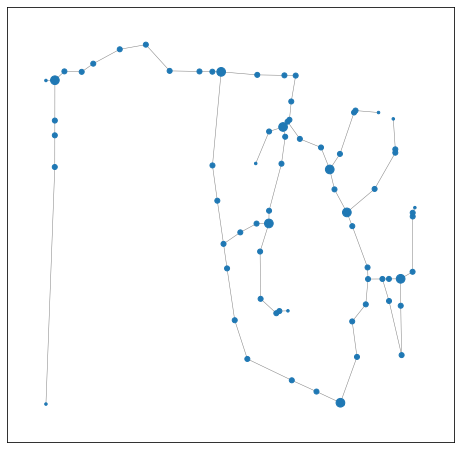

In [23]:
compute(G, pos, nx.pagerank(G))

#### HITS

/home/ichatz/.local/lib/python3.8/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


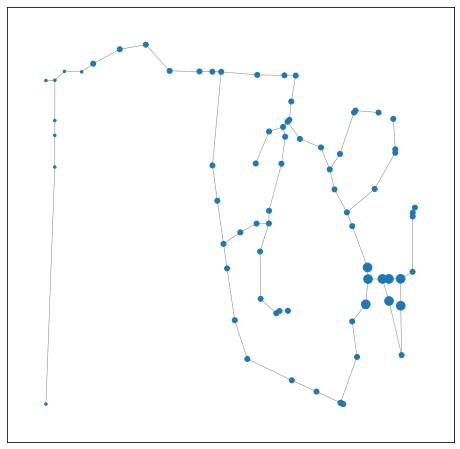

In [24]:
compute(G, pos, nx.hits(G)[0])

### Comunities

In [25]:
from networkx.algorithms import community

In [27]:
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

In [28]:
communities = sorted(map(sorted, next_level_communities))

In [30]:
colors_available = ['red', 'blue', 'green', 'yellow']

In [35]:
color = {}

In [42]:
com_color = -1
for community in communities:
    com_color += 1
    for node in community:
        color[node] = colors_available[com_color]
        G.nodes[node]['color'] = colors_available[com_color]

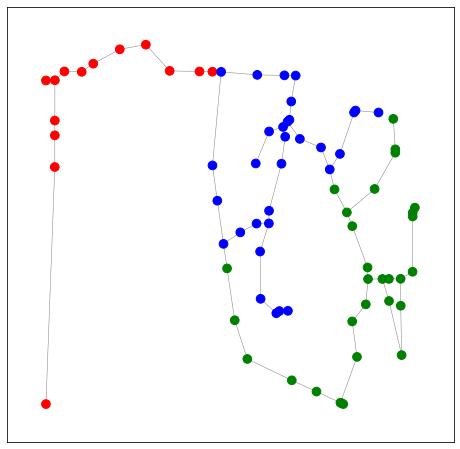

In [45]:
plt.figure(figsize=(8,8))
plt.clf()
nx.draw_networkx_nodes(G, pos=pos, 
                       node_shape='.', 
                       node_color=list(nx.get_node_attributes(G, 'color').values()))
nx.draw_networkx_edges(G, pos=pos, width=0.5, alpha=0.5)
plt.show()   